# My "0-day experiment" of:
## "Diagnosis of systemic risk and contagion across financial sectors"
## https://arxiv.org/pdf/2101.06585.pdf

### Their data is obtained from the Center for Research in Security Prices (CRSP) via Wharton School of Economics - Wharton Research Data Services (WRDS).

### I personally do not have access to this database, however, I was able to reconstruct their data.

### Every SEC SIC industrial code has a description which noisily maps to ticker groups compiled by Barchart.com

## “Division of Corporation Finance: Standard Industrial Classification (SIC) Code List”:
### https://www.sec.gov/corpfin/division-of-corporation-finance-standard-industrial-classification-sic-code-list

## Sector Lists – Barchart:
### https://barchart.websol.barchart.com/?module=industryDetail&lang=en&symbol=FIN

In [2]:
sector_dc = {'Banks':
             {
                 'National Commercial Banks': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-602B&override=&region=',
                 'State Commercial Banks': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-602C&override=&region=',
                 'Functions related to Depository Banking Nec': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-609J&override=&region=',
                 'Commercial Banks Nec': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-602J&override=&region=',
                 'Savings Institution Federally Chartered': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-603F&override=&region=',
                 'Savings Institutions Not Federally Chartered': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-603G&override=&region=',
                 'Federal and Federally Sponsored Credit Agencies': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-611B&override=&region=',
                 'Personal Credit Institutions': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-614B&override=&region=',
                 'Short-Term Business Credit Institutions': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-615D&override=&region=',
                 'Miscellaneous Business Credit Institutions': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-615J&override=&region=',
                 'Mortgage Bankers and Loan Correspondents': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-616C&override=&region=',
                 'Loan Brokers': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-616D&override=&region=',
                 'Finance Services': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-619J&override=&region='},
             'Brokerages':
             {
                 'Security and Commodity Brokers, Dealers, Exchanges, and Services': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-620A&override=&region=',
                 'Security Brokers, Dealers and Flotation Companies': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-621B&override=&region=',
                 'Commodity Contracts Brokers and Dealers': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-622B&override=&region='},
             'Insurers':
             {
                 'Life Insurance': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-INLI&override=&region=',
                 'Accident and Health Insurance': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-INAH&override=&region=',
                 'Insurance – Multi Line': 'https://barchart.websol.barchart.com/?module=sectorDetail&lang=en&symbol=-INML&override=&region='
             }
}


### Quick webscraper

In [3]:
import datetime
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from collections import defaultdict

subsector_tickers = defaultdict(str)
for sector in sector_dc:
    subsector_tickers[sector] = defaultdict(list)
    for subsector in sector_dc[sector]:
        url = sector_dc[sector][subsector]
        page = requests.get(url)
        df_list = pd.read_html(page.text) # this parses all the tables in webpages to a list
        df = df_list[1]
        subsector_tickers[sector][subsector] = list(df['Sym'].values)

### Grouping sector and subsector historical daily prices - obtained from Yahoo Finance

In [5]:
subsector_df_dc = {}

for sector in subsector_tickers:
    for subsector in subsector_tickers[sector]:
        hist_dict = {}
        for ticker in subsector_tickers[sector][subsector]:
            try:
                hist = yf.Ticker(ticker).history(period="max")
                hist_dict[ticker] = hist
            except:
                continue
        if sector not in subsector_df_dc:
            subsector_df_dc[sector] = {}
        subsector_df_dc[sector][subsector] = pd.concat(hist_dict, axis=1)

In [3]:
def reform_dict(dictionary, t=tuple(), reform={}):
    for key, val in dictionary.items():
        t = t + (key,)
        if isinstance(val, dict):
            reform_dict(val, t, reform)
        else:
            reform.update({t: val})
        t = t[:-1]
    return reform
df = pd.concat(reform_dict(subsector_df_dc), axis=1)
df = df.iloc[df.index.get_loc(datetime.datetime(2007,1,1),method='nearest'):]
df.to_pickle('Industrial_Sector_DataFrames.pkl')
df = pd.read_pickle('Industrial_Sector_DataFrames.pkl')
df

Banks                                   \
           National Commercial Banks                                    
                                AMTB                                    
                                Open       High        Low      Close   
Date                                                                    
2007-01-03                       NaN        NaN        NaN        NaN   
2007-01-04                       NaN        NaN        NaN        NaN   
2007-01-05                       NaN        NaN        NaN        NaN   
2007-01-08                       NaN        NaN        NaN        NaN   
2007-01-09                       NaN        NaN        NaN        NaN   
...                              ...        ...        ...        ...   
2021-12-17                 33.252965  36.657126  32.733855  35.568993   
2021-12-20                 34.940067  35.149707  33.362771  34.980000   
2021-12-21                 35.380001  35.880001  33.869999  34.200001   
2021-12-22                 34.189999  34.820000  33.939999  34.590000   
2021-12-23                 34.750000  34.750000  34.035000  34.139999   

                                                                     \
                                                                      
                                                   HAFC               
              Volume Dividends Stock Splits        Open        High   
Date                                                                  
2007-01-03       NaN       NaN          NaN  137.564377  140.226136   
2007-01-04       NaN       NaN          NaN  137.806350  139.742171   
2007-01-05       NaN       NaN          NaN  137.443430  138.108873   
2007-01-08       NaN       NaN          NaN  133.632242  133.692738   
2007-01-09       NaN       NaN          NaN  133.148256  133.692707   
...              ...       ...          ...         ...         ...   
2021-12-17  489400.0      0.00          0.0   22.510000   23.580000   
2021-12-20  226100.0      0.00          0.0   22.410000   22.410000   
2021-12-21  146800.0      0.06          0.0   22.290001   22.780001   
2021-12-22  120800.0      0.00          0.0   22.330000   22.760000   
2021-12-23   60213.0      0.00          0.0   22.840000   22.990000   

                        ...               Insurers                         \
                        ... Insurance – Multi Line                          
                        ...                   IGIC                          
                   Low  ...                 Volume Dividends Stock Splits   
Date                    ...                                                 
2007-01-03  135.326089  ...                    NaN       NaN          NaN   
2007-01-04  135.628546  ...                    NaN       NaN          NaN   
2007-01-05  133.571788  ...                    NaN       NaN          NaN   
2007-01-08  131.817413  ...                    NaN       NaN          NaN   
2007-01-09  130.728481  ...                    NaN       NaN          NaN   
...                ...  ...                    ...       ...          ...   
2021-12-17   21.580000  ...                 3800.0       0.0          0.0   
2021-12-20   21.290001  ...                 5700.0       0.0          0.0   
2021-12-21   22.260000  ...                 3100.0       0.0          0.0   
2021-12-22   22.290001  ...                25600.0       0.0          0.0   
2021-12-23   22.709999  ...                18986.0       0.0          0.0   

                                                                             \
                                                                              
                  RDN                                                         
                 Open       High        Low      Close     Volume Dividends   
Date                                                                          
2007-01-03  49.868264  51.498007  49.822227  50.807438   934100.0       0.0   
2007-01-04  50.807

### Single Stock Empirical Returns Calculation

In [136]:
for sector_subsector in list(set([mi[:2] for mi in list(df.columns)])):
    close_cols = [c for c in df[sector_subsector].columns if c[1] == 'Close']
    new_cols = [(sector_subsector[0], sector_subsector[1], c[0], 'Return') for c in close_cols]
    data_matrix = (df[sector_subsector][close_cols].values[1:] - df[sector_subsector][close_cols].values[:-1])/df[sector_subsector][close_cols].values[:-1]
    for idx, new_col in enumerate(new_cols):
        v = np.zeros(data_matrix.shape[0] + 1)
        v[1:] = data_matrix[:, idx]
        df[new_col] = v
df

Banks                                   \
           National Commercial Banks                                    
                                AMTB                                    
                                Open       High        Low      Close   
Date                                                                    
2007-01-03                       NaN        NaN        NaN        NaN   
2007-01-04                       NaN        NaN        NaN        NaN   
2007-01-05                       NaN        NaN        NaN        NaN   
2007-01-08                       NaN        NaN        NaN        NaN   
2007-01-09                       NaN        NaN        NaN        NaN   
...                              ...        ...        ...        ...   
2021-12-17                 33.252965  36.657126  32.733855  35.568993   
2021-12-20                 34.940067  35.149707  33.362771  34.980000   
2021-12-21                 35.380001  35.880001  33.869999  34.200001   
2021-12-22                 34.189999  34.820000  33.939999  34.590000   
2021-12-23                 34.750000  34.750000  34.035000  34.139999   

                                                                     \
                                                                      
                                                   HAFC               
              Volume Dividends Stock Splits        Open        High   
Date                                                                  
2007-01-03       NaN       NaN          NaN  137.564377  140.226136   
2007-01-04       NaN       NaN          NaN  137.806350  139.742171   
2007-01-05       NaN       NaN          NaN  137.443430  138.108873   
2007-01-08       NaN       NaN          NaN  133.632242  133.692738   
2007-01-09       NaN       NaN          NaN  133.148256  133.692707   
...              ...       ...          ...         ...         ...   
2021-12-17  489400.0      0.00          0.0   22.510000   23.580000   
2021-12-20  226100.0      0.00          0.0   22.410000   22.410000   
2021-12-21  146800.0      0.06          0.0   22.290001   22.780001   
2021-12-22  120800.0      0.00          0.0   22.330000   22.760000   
2021-12-23   60213.0      0.00          0.0   22.840000   22.990000   

                        ...               Insurers                      \
                        ... Insurance – Multi Line                       
                        ...                   ESGR       ORI      GSHD   
                   Low  ...                 Return    Return    Return   
Date                    ...                                              
2007-01-03  135.326089  ...               0.000000  0.000000  0.000000   
2007-01-04  135.628546  ...               0.026576 -0.007231       NaN   
2007-01-05  133.571788  ...              -0.007716 -0.011997       NaN   
2007-01-08  131.817413  ...              -0.003376 -0.009540       NaN   
2007-01-09  130.728481  ...               0.002464 -0.001751       NaN   
...                ...  ...                    ...       ...       ...   
2021-12-17   21.580000  ...              -0.018837 -0.028214 -0.042399   
2021-12-20   21.290001  ...              -0.012282 -0.036085 -0.022657   
2021-12-21   22.260000  ...               0.018249  0.027108  0.076973   
2021-12-22   22.290001  ...               0.013962  0.002933  0.035850   
2021-12-23   22.709999  ...               0.023142  0.005848  0.010390   

                                                                        \
                                                                         
                  CI       AIZ       MTG       CNO      DWIN      IGIC   
              Return    Return    Return    Return    Return    Return   
Date                                                                     
2007-01-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2007-01-04 -0.018894  0.009849  0.003782 -0.002978       NaN       NaN   
2007-01-05 -0.007038 -

### Uniformly-weighted Industrial Sector Daily Empirical Returns

### I chose uniform-weighting as there is no free source for daily ticker Market Capitalization. In the past, I've used Polygon (polygon.io) for this purpose ($200.00/mo). 

### The most glaring and obvious improvement is for Market Capitalization Weightings for these (Financial or Financially-Adjacent) Industrial Sector ETFs

In [180]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
etf_df = pd.DataFrame(index=df.index)
for sector_subsector in tqdm(list(set([mi[:2] for mi in list(df.columns)]))):
    return_cols = [(sector_subsector[0], sector_subsector[1], c[0], 'Return') for c in df[sector_subsector].columns if c[1] == 'Close']
    R = np.zeros(df.shape[0])
    for idx in tqdm(range(df.shape[0])):
        slc_df = df.iloc[idx][return_cols]
        slc_df = slc_df[[i[0] for i in dict(pd.isna(slc_df)).items() if i[1] == False]]
        if slc_df.shape[0] == 0:
            continue
        else:
            R[idx] = (slc_df.values * (1/slc_df.shape[0])).sum()
    etf_df[(sector_subsector[0], sector_subsector[1], 'Return')] = R
    
etf_df.columns = pd.MultiIndex.from_tuples(etf_df.columns)
etf_df = etf_df[etf_df.columns.sort_values()]
etf_df

Banks  \
           Commercial Banks Nec   
                         Return   
Date                              
2007-01-03             0.000000   
2007-01-04            -0.006028   
2007-01-05            -0.008813   
2007-01-08             0.002230   
2007-01-09            -0.005602   
...                         ...   
2021-12-17            -0.016038   
2021-12-20            -0.009873   
2021-12-21             0.014803   
2021-12-22             0.010921   
2021-12-23             0.011917   

                                                                             \
           Federal and Federally Sponsored Credit Agencies Finance Services   
                                                    Return           Return   
Date                                                                          
2007-01-03                                        0.000000         0.000000   
2007-01-04                                       -0.011586        -0.004581   
2007-01-05                                       -0.049084        -0.007807   
2007-01-08                                        0.002311        -0.000717   
2007-01-09                                        0.003844         0.014770   
...                                                    ...              ...   
2021-12-17                                       -0.011322        -0.001971   
2021-12-20                                       -0.004359        -0.027577   
2021-12-21                                        0.027983         0.035252   
2021-12-22                                        0.001002         0.005847   
2021-12-23                                        0.006590         0.001844   

                                                                     \
           Functions related to Depository Banking Nec Loan Brokers   
                                                Return       Return   
Date                                                                  
2007-01-03                                    0.000000     0.000000   
2007-01-04                                    0.050013     0.000000   
2007-01-05                                    0.046597     0.000000   
2007-01-08                                   -0.005132     0.000000   
2007-01-09                                   -0.035080     0.000000   
...                                                ...          ...   
2021-12-17                                    0.066722     0.032586   
2021-12-20                                   -0.001446    -0.073708   
2021-12-21                                    0.028903     0.061427   
2021-12-22                                   -0.001116     0.001601   
2021-12-23                                   -0.002667     0.007753   

                                                       \
           Miscellaneous Business Credit Institutions   
                                               Return   
Date                                                    
2007-01-03                                   0.000000   
2007-01-04                                   0.007948   
2007-01-05                                  -0.007341   
2007-01-08                                   0.010888   
2007-01-09                                   0.009281   
...                                               ...   
2021-12-17                                   0.004167   
2021-12-20                                  -0.018476   
2021-12-21                                   0.006543   
2021-12-22                                   0.002300   
2021-12-23                                   0.007184   

                                                                               \
           Mortgage Bankers and Loan Correspondents National Commercial Banks   
                                             Return                    Return   
Date                                                                            
2007-01-03                                 0.000000                 

## Quick Eigen-Decomposition-And-Reconstruction Test

In [247]:
thresh = 1*10**-12

for e_idx in range(k, etf_df.shape[0]):
    s_idx = e_idx - k
    slc_etf_df = etf_df.iloc[s_idx:e_idx]
    slc_etf_df_mu = slc_etf_df.mean(0)
    M = (slc_etf_df - slc_etf_df_mu).values.T
    SIG = M @ M.T
    w, v = np.linalg.eig(SIG)
    break

# Maximum 
assert np.abs(SIG - (v @ np.diag(w) @ v.T)).max() < thresh

## Plotting Correlation Matrix and Eigen-decomposition reconstruction side-by-side

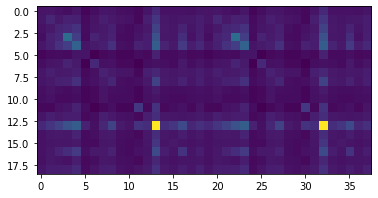

In [288]:
plt.imshow(np.concatenate((SIG, (v @ np.diag(w) @ v.T)), 1))

### "The 1st fractional eigenvalue is the ideal data point to record as it is the most accurate measure of the concentration of variation between assets... Being the most accurate measure for concentration of variation in asset movements it is then also the ideal systemic risk indicator as increased concentration in the variation of assets means increasingly similar movements and market friction" 
### The assets in this case are the uniformly-weighted Industrial Sector ETFs Daily Empirical Returns.
### For those unfamiliar or unrefreshed on Eigen-decomposition, this is a particularly beautiful and informative youtube video on that topic: https://www.youtube.com/watch?v=PFDu9oVAE-g

In [261]:
EIG_df = pd.DataFrame(index=etf_df.index[k:])
EIG_df['First Fractional Eigenvalue'] = 0

for idx, e_idx in tqdm(enumerate(range(k, etf_df.shape[0]))):
    s_idx = e_idx - k
    slc_etf_df = etf_df.iloc[s_idx:e_idx]
    slc_etf_df_mu = slc_etf_df.mean(0)
    M = (slc_etf_df - slc_etf_df_mu).values.T
    SIG = M @ M.T
    w, v = np.linalg.eig(SIG)
    EIG_df.iloc[idx] = (w/w.sum()).max()

0it [00:00, ?it/s]

### Plotting the 1st fractional eigenvalue against the SPY. 

### Re-iterating, the most obvious improvement is for Market Capitalization Weightings of the respective ETFs, for which I would like to repeat this. In lieu of that, there is a rough alignment of the indicator and extreme movements of the SPY. The indicator aligns with the 2020 Covid Crash and subsequent Bull Run, and the very recent Omicron mini-crash.

<Figure size 432x288 with 0 Axes>

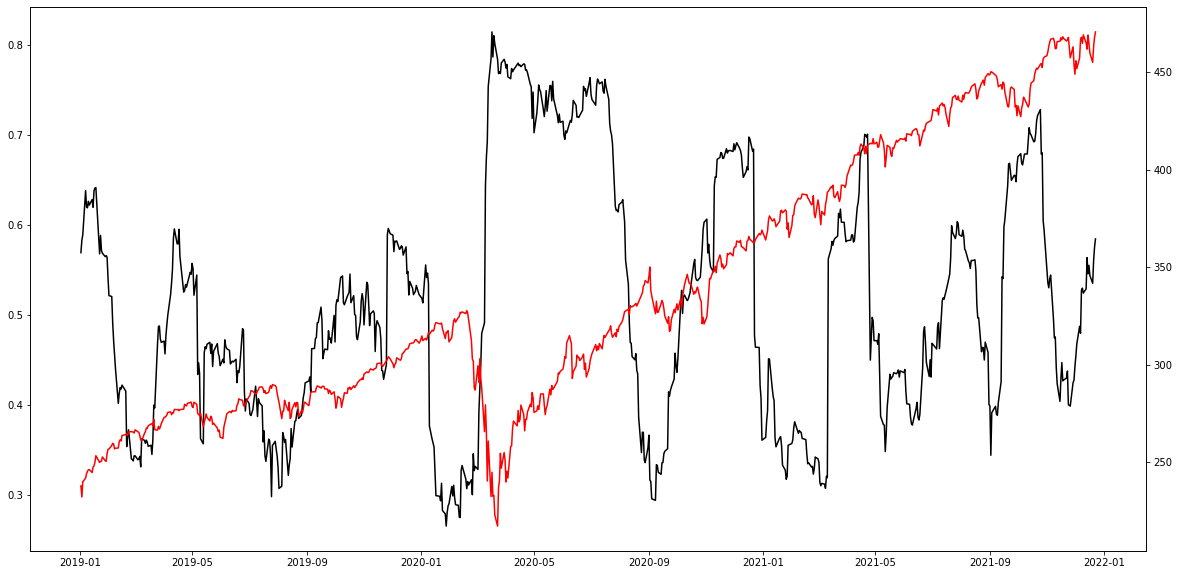

In [292]:
spy_df = yf.Ticker('SPY').history(period="max")
slc_EIG_df = EIG_df.iloc[EIG_df.index.get_loc(datetime.datetime(2019,1,1),method='nearest'):]
slc_spy_df = spy_df.loc[spy_df.index.intersection(slc_EIG_df.index)]['Close']

fig = figure()
fig, ax_left = plt.subplots(figsize=(20,10))

ax_right = ax_right = ax_left.twinx()

ax_left.plot(slc_EIG_df, color='black')
ax_right.plot(slc_spy_df, color='red')